### Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import time, pickle, joblib, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# load data and define x and y
df = pd.read_csv('df_preproc_02.csv')
y = df['Label']
X = df.drop(['Label'], axis = 1)

In [4]:
# balance data
import imblearn
from imblearn.under_sampling import RandomUnderSampler
#imblearn.__version__
und = RandomUnderSampler('majority')
X_und, y_und = und.fit_resample(X,y)

In [5]:
y_und.value_counts()

DDoS            128014
PortScan         90694
Web Attack        2143
Bot               1948
Infiltration        36
BENIGN              36
Name: Label, dtype: int64

In [6]:
df_tmp = X_und
df_tmp['Label'] = y_und
minor = pd.DataFrame(df_tmp[(df_tmp['Label']!=4) & (df_tmp['Label']!=2)])
major = pd.DataFrame(df_tmp[(df_tmp['Label']==4) | (df_tmp['Label']==2)])
minor['Label'].value_counts()

DDoS            128014
PortScan         90694
Web Attack        2143
Bot               1948
Infiltration        36
BENIGN              36
Name: Label, dtype: int64

In [7]:
print('original shape:     ',df.shape)
print('undersampled shape: ',minor.shape)

original shape:      (1017939, 13)
undersampled shape:  (222871, 13)


In [8]:
# split dataset
from sklearn.model_selection import train_test_split

train, test = train_test_split(minor,test_size = 0.3, random_state=10)
# attack distribution
display(train['Label'].value_counts())
display(test['Label'].value_counts())

DDoS            89665
PortScan        63448
Web Attack       1527
Bot              1317
Infiltration       27
BENIGN             25
Name: Label, dtype: int64

DDoS            38349
PortScan        27246
Bot               631
Web Attack        616
BENIGN             11
Infiltration        9
Name: Label, dtype: int64

### Standarziation
numerical atrribute를 standardize함

In [9]:
# scale numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))
# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [10]:
from sklearn.preprocessing import OneHotEncoder 
# creating one hot encoder object 
onehotencoder = OneHotEncoder() 
trainDep = train['Label'].values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test['Label'].values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

In [11]:
train_X = sc_traindf
train_y = trainDep[:,0]
test_X = sc_testdf
test_y = testDep[:,0]

### Feature Selection - Filter
Anova (F-value)를 이용해 K best feature를 선택

In [12]:
# use anova (f-value) to select k best features (filter)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

best_feat = SelectKBest(score_func = f_classif, k = 10)
fit = best_feat.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

feat_scores = pd.concat([df_columns, df_scores], axis=1)
feat_scores.columns = ['Specs', 'Score']
n = len(feat_scores['Specs'])
print(feat_scores.nlargest(n,'Score'))

feat = pd.DataFrame()
for i in feat_scores.nlargest(n,'Score')['Specs']:
        feat[i] = df[i]
        
feat['Label'] = df['Label']   
feat.shape

                     Specs          Score
0    Bwd Packet Length Std  178692.286552
1           PSH Flag Count   46150.082885
2     min_seg_size_forward   42682.730181
3        Min Packet Length   23779.326890
5    Bwd Packet Length Min   19292.824337
4           ACK Flag Count   17121.773827
6              Fwd IAT Std   15124.767553
7   Init_Win_bytes_forward   11548.267409
8             Flow IAT Max   11342.823816
9            Bwd Packets/s    8629.073721
10          URG Flag Count    6795.045490
11           Bwd IAT Total    5905.079784


(1017939, 13)

### Feature Selection - Embedded
Random Forest<br>
Gradient Boosting<br>
XGBoost

In [14]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0)
gbc_model = gbc.fit(train_X,train_y)

train_score = gbc.score(train_X,train_y)
print('train set score: {:.3f}'.format(train_score))
test_score = gbc.score(test_X,test_y)
print('test set score: {:.3f}'.format(test_score))

# pruning
gbc_prnd = GradientBoostingClassifier(random_state=0,max_depth=1)
gbc_prnd_model = gbc_prnd.fit(train_X,train_y)

train_score_prnd = gbc_prnd.score(train_X,train_y)
print('train set score (pruned): {:.3f}'.format(train_score_prnd))
test_score_prnd = gbc_prnd.score(test_X,test_y)
print('test set score (pruned): {:.3f}'.format(test_score_prnd))

train set score: 1.000
test set score: 0.997
train set score (pruned): 1.000
test set score (pruned): 1.000


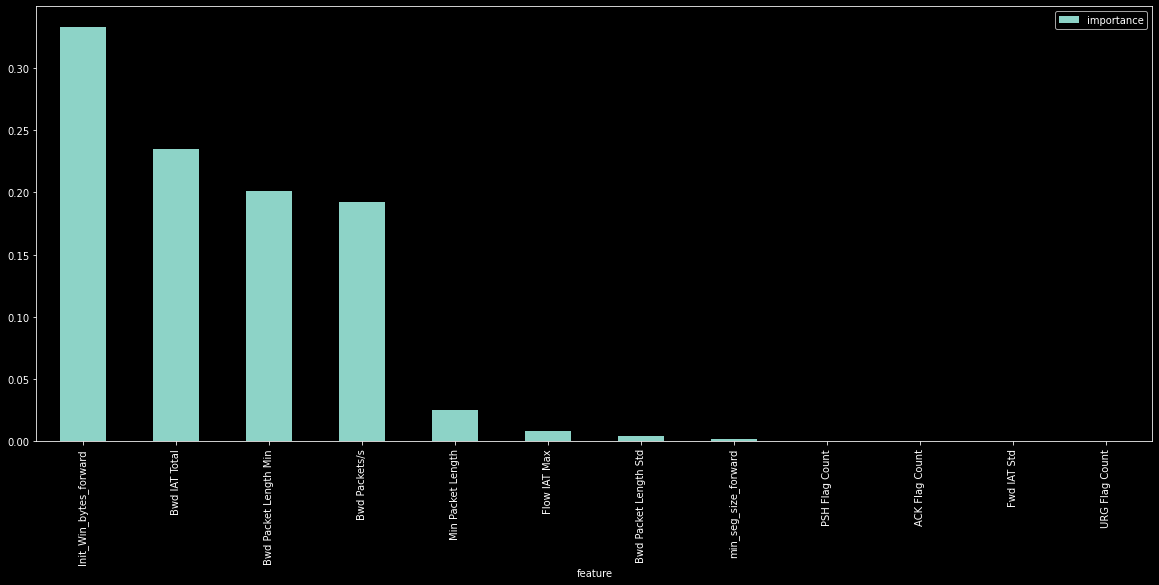

In [15]:
# Gradient Boosting - plot feature importance
score = np.round(gbc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
plt.rcParams['figure.figsize'] = (20,8)
plt.style.use('dark_background')
importances.plot.bar()
plt.show()

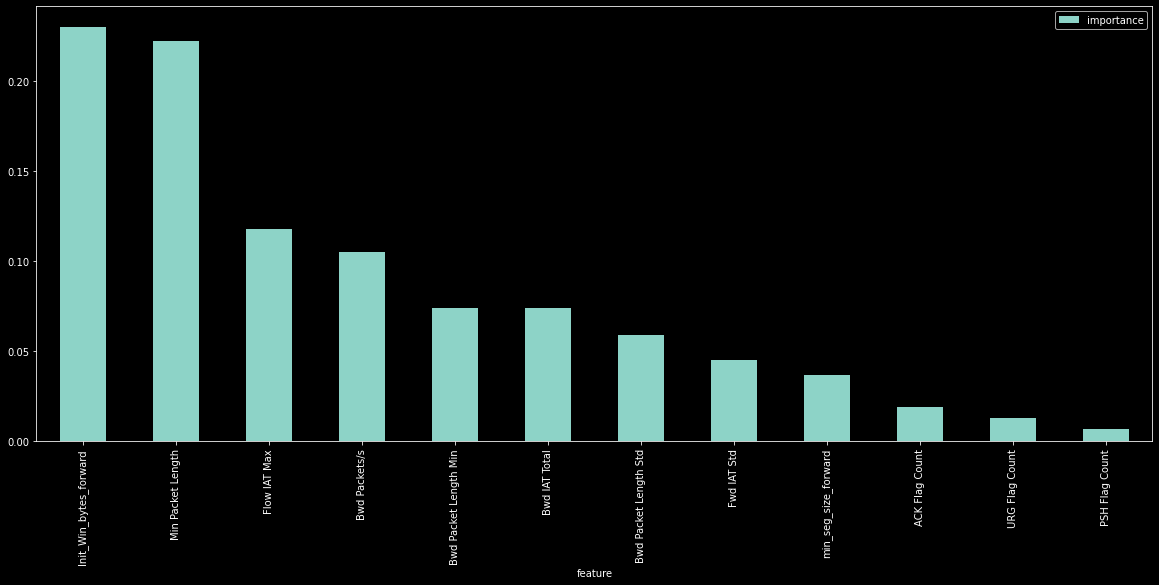

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (20, 8)
importances.plot.bar()
plt.show()

[22:11:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


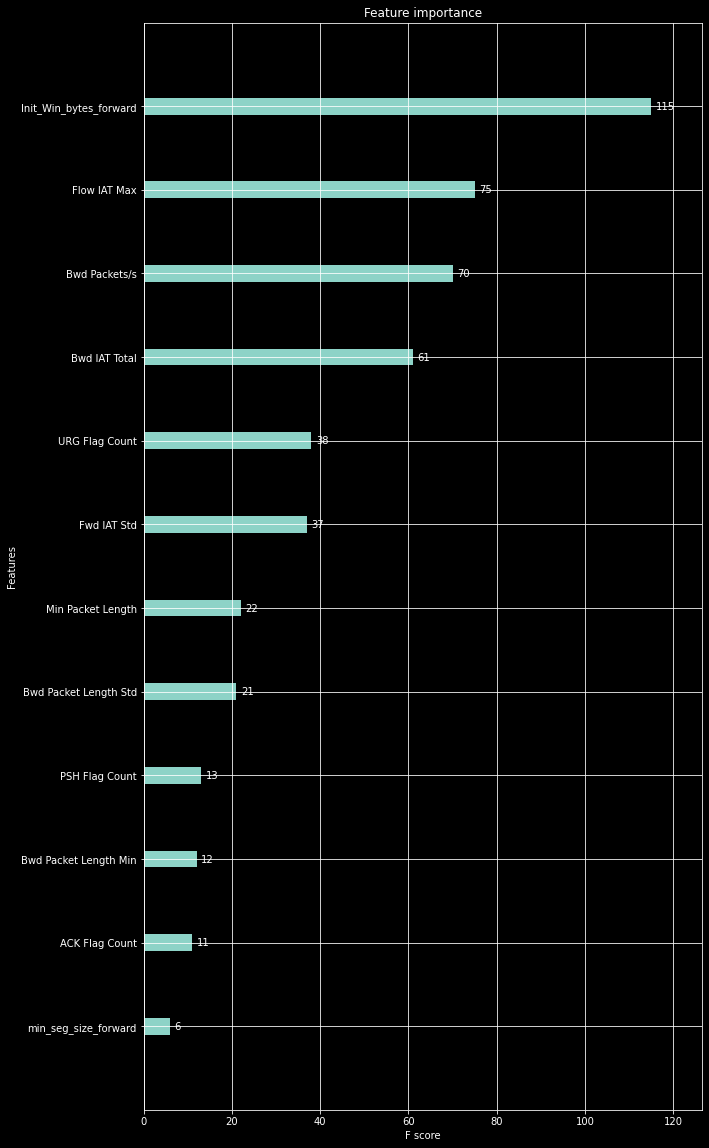

In [17]:
# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

xgb = XGBClassifier(random_state=42)
xgb_model = xgb.fit(train_X,train_y)
# plot feature importance
plt.rcParams['figure.figsize'] = (10,20)
plot_importance(xgb_model)
plt.show()

### ML Models

In [26]:
X_train = sc_traindf
y_train = trainDep[:,0]
X_test = sc_testdf
y_test = testDep[:,0]

In [27]:
# Train models
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Train Naive-Bayes Model
startNB = time.time()
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, y_train)
filename = 'naive_bayes_train_model.sav'
pickle.dump(BNB_Classifier, open(filename, 'wb'))
print('Naive Bayes model trained\n')
print('Elapsed time: ',time.time()-startNB)

# Train KNeighborsClassifier Model
startKNN = time.time()
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, y_train)
filename = 'knn_train_model.sav'
pickle.dump(KNN_Classifier, open(filename, 'wb'))
print('KNN model trained\n')
print('Elapsed time: ',time.time()-startKNN)

# Train LogisticRegression Model
startLGR = time.time()
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, y_train)
filename = 'linear_regression_train_model.sav'
pickle.dump(LGR_Classifier, open(filename, 'wb'))
print('Linear Regression model trained\n')
print('Elapsed time: ',time.time()-startLGR)

# Train Decision Tree Model
startDT = time.time()
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, y_train)
filename = 'decision_tree_train_model.sav'
pickle.dump(DTC_Classifier, open(filename, 'wb'))
print('Decision Tree model trained\n')
print('Elapsed time: ',time.time()-startDT)

# Train Random Forest Model
startRF = time.time()
RFC_Classifier = RandomForestClassifier(max_depth=40)
RFC_Classifier.fit(X_train, y_train)
filename = 'random_forest_train_model.sav'
pickle.dump(RFC_Classifier, open(filename, 'wb'))
print('Random Forest model trained\n')
print('Elapsed time: ',time.time()-startRF)

# Train Gradient Boosting Model
startGB = time.time()
GBC_Classifier = GradientBoostingClassifier()
GBC_Classifier.fit(X_train,y_train)
filename = 'gradient_boosting_train_model.sav'
pickle.dump(GBC_Classifier, open(filename, 'wb'))
print('Gradient Boosting model trained\n')
print('Elapsed time: ',time.time()-startGB)

# Train XGBoost Model
startXGB = time.time()
XGB_Classifier = XGBClassifier(criterion='entropy', random_state=0)
XGB_Classifier.fit(X_train,y_train)
filename = 'xgboost_train_model.sav'
pickle.dump(XGB_Classifier, open(filename, 'wb'))
print('XGBoost model trained\n')
print('Elapsed time: ',time.time()-startXGB)

# xgbpreds = xgb.predict(x_test)
# print("Accuracy",accuracy_score(y_test,xgbpreds))
# print(classification_report(y_test,xgbpreds))

Naive Bayes model trained

Elapsed time:  0.04600024223327637
KNN model trained

Elapsed time:  13.623625755310059
Linear Regression model trained

Elapsed time:  3.853790760040283
Decision Tree model trained

Elapsed time:  0.3158755302429199
Random Forest model trained

Elapsed time:  5.703205585479736
Gradient Boosting model trained

Elapsed time:  13.895508766174316
[22:34:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:34:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. 

In [29]:
# Evaluate Models
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('KNeighbors Classifier', KNN_Classifier))
models.append(('Logistic Regression Classifier', LGR_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('Random Forest Classifier', RFC_Classifier))
models.append(('Gradient Boosting Classifier', GBC_Classifier))
models.append(('XGBoost Classifier', XGB_Classifier))


for i, v in models:
    Xpred =  v.predict(X_train)
    scores = cross_val_score(v, X_train, Y_train, cv=10) # k=10 fold cross validation
    accuracy = metrics.accuracy_score(Y_train, Xpred)
    confusion_matrix = metrics.confusion_matrix(Y_train, Xpred)
    classification = metrics.classification_report(Y_train, Xpred)
    print()
    print('========================== {} Model Evaluation =========================='.format(i))
    print()
    print ('Cross Validation Mean Score: ',scores.mean())
    print()
    print ('Model Accuracy: ',accuracy)
    print()
    print('Confusion matrix:' '\n',confusion_matrix)
    print()
    print('Classification report:' '\n',classification) 
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9998397530401568

Model Accuracy:
 0.9998397528347723

Confusion matrix:
 [[155984      0]
 [    25      0]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    155984
         1.0       0.00      0.00      0.00        25

    accuracy                           1.00    156009
   macro avg       0.50      0.50      0.50    156009
weighted avg       1.00      1.00      1.00    156009



============================== KNeighbors Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9998910326261138

Model Accuracy:
 0.9998910319276452

Confusion matrix:
 [[155983      1]
 [    16      9]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    155984
         1.0       0.90  

[22:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:43:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used bu

In [30]:
# Validate Models
for i, v in models:
    pred = v.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test,pred)
    confusion_matrix = metrics.confusion_matrix(Y_test, pred)
    classification = metrics.classification_report(Y_test, pred)
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ('Model Accuracy: ',accuracy)
    print()
    print('Confusion matrix:' '\n',confusion_matrix)
    print()
    print('Classification report:' '\n',classification) 
    print()    


============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.9998354820376297

Confusion matrix:
 [[66851     0]
 [   11     0]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     66851
         1.0       0.00      0.00      0.00        11

    accuracy                           1.00     66862
   macro avg       0.50      0.50      0.50     66862
weighted avg       1.00      1.00      1.00     66862



============================== KNeighbors Classifier Model Test Results ==============================

Model Accuracy:
 0.999895306751219

Confusion matrix:
 [[66851     0]
 [    7     4]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     66851
         1.0       1.00      0.36      0.53        11

    accuracy                           1.00     66862
   macro avg       1.

In [31]:
# # Prediction (test dataset)
# pred_bnb = BNB_Classifier.predict(X_test)
# pred_knn = KNN_Classifier.predict(X_test)
# pred_lgr = LGR_Classifier.predict(X_test)
# pred_dtc = DTC_Classifier.predict(X_test)
# pred_rfc = RFC_Classifier.predict(X_test)
# pred_gbc = GBC_Classifier.predict(X_test)
# pred_xgb = XGB_Classifier.predict(X_test)

### Nueral Network Model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# encode predictor variable (y)
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

In [ ]:
# define baseline model
def baseline_model():
	model = Sequential()
	model.add(Dense(8, input_dim=4, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model,
                            epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10,shuffle=True)
# evaluate with cross validation
results = cross_val_score(estimator, X, dummy_y, cv = kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

y = df['Label']
X = df.drop(['Label'], axis = 1)
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 10)

# define the model (multi-class classification)
def baseline_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, activation='sigmoid'))
	model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
	return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = X.shape, y.shape
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = baseline_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# make a prediction on the test set
		yhat = model.predict(X_test)
		# round probabilities to class labels
		yhat = yhat.round()
		# calculate accuracy
		acc = accuracy_score(y_test, yhat)
		# store result
		print('>%.3f' % acc)
		results.append(acc)
	return results
 
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))